In [1]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import librosa
from IPython import display
import sys
sys.path.append("../")
from DSP_prototype.DSP_algorithms import stft
import tensorflow as tf
from tensorflow import keras
import tensorflow_model_optimization as tfmot
import os
import csv
import tempfile

2025-01-19 01:33:54.452577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737246834.468497   11258 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737246834.473307   11258 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 01:33:54.489390: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
sample_rate = 16000
label_strings = ["down", "go", "left", "no", "off", "on", "right", "stop", "up", "yes", "silence", "unknown"]
selected_labels = [1, 2, 6, 7]
selected_labels_dict = {x:i for i, x in enumerate(selected_labels)}
NUM_CLASSES = len(selected_labels)
commands = [label_strings[x] for x in selected_labels]
selected_labels_str = [label_strings[x] for x in selected_labels]
prediction_dict = {i: label for i, label in enumerate(selected_labels_str)}
prediction_dict_reversed = {label: i for i, label in enumerate(selected_labels_str)}

In [3]:
dataset, info = tfds.load('speech_commands', with_info=True, as_supervised=True, split="test+validation+train")
print(f"Full dataset length: {len(dataset)}")

exclude_classes = [x for x in range(12) if x not in selected_labels]
dataset = dataset.shuffle(10000, seed=2137)

I0000 00:00:1737246836.393049   11258 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 665 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 Super, pci bus id: 0000:01:00.0, compute capability: 7.5


Full dataset length: 100503


In [4]:
noise = []
with open("../Data_acquisition/data/audio/8kHz_augmented/silence_fs=8kHz_10_pitch=0.csv", 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        noise.append(float(row['y']))  # Convert to int if y is numeric

    file.close()
noise = np.array(noise)

In [5]:
def split_data_and_labels(dataset, length):
    data = []
    labels = []
    i = 0
    unknown_counter = 0
    for feature, label in dataset:
        if i == length:
            break
            
        pcm = feature.numpy()
        pcm_padded = np.pad(pcm, (0, sample_rate - len(pcm)), 'constant', constant_values=0)
        pcm_padded = pcm_padded.astype(np.float32)
        pcm_padded = librosa.resample(pcm_padded, orig_sr=16e3, target_sr=8e3)
        
        label = int(label.numpy())
        if label in selected_labels:
            if label == 11 and unknown_counter < 5:
                unknown_counter += 1
                
            if (label == 11 and unknown_counter == 5) or label != 11:
                #pcm_padded= nr.reduce_noise(y=pcm_padded, y_noise=noise, sr=8000)
                data.append(pcm_padded)
                labels.append(selected_labels_dict.get(label))
                i += 1
                unknown_counter = 0
    return np.vstack(data), np.vstack(labels)


In [6]:
data, dataset_labels = split_data_and_labels(dataset, len(dataset))
NEW_DATASET_LENGTH = len(data)
print(f"Filtered length: {NEW_DATASET_LENGTH}")

2025-01-19 01:33:57.639967: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


Filtered length: 15331


2025-01-19 01:34:49.361884: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
TRAIN_PART = 0.7
VAL_PART = 0.1
TEST_PART = 0.2

train_data = data[:int(NEW_DATASET_LENGTH*TRAIN_PART)]
train_labels = dataset_labels[:int(NEW_DATASET_LENGTH*TRAIN_PART)]
TRAIN_LEN = len(train_data)

val_data = data[TRAIN_LEN:TRAIN_LEN+int(NEW_DATASET_LENGTH*VAL_PART)]
val_labels = dataset_labels[TRAIN_LEN:TRAIN_LEN+int(NEW_DATASET_LENGTH*VAL_PART)]
VAL_LEN = len(val_data)

test_data = data[TRAIN_LEN+VAL_LEN:]
test_labels = dataset_labels[TRAIN_LEN+VAL_LEN:]
TEST_LEN = len(test_data)

print(f"Train data length: {TRAIN_LEN}")
print(f"Validation data length: {VAL_LEN}")
print(f"Test data length: {TEST_LEN}")
print(f"Full dataset length: {NEW_DATASET_LENGTH}")

Train data length: 10731
Validation data length: 1533
Test data length: 3067
Full dataset length: 15331


In [8]:
print(f"[Train dataset] Max amplitude before normalization: {np.max(np.abs(train_data))}")
print(f"[Valid dataset] Max amplitude before normalization: {np.max(np.abs(val_data))}")
print(f"[Test dataset] Max amplitude before normalization: {np.max(np.abs(test_data))}")

train_data_max = np.max(np.abs(train_data))
valid_data_max = np.max(np.abs(val_data))
test_data_max = np.max(np.abs(test_data))

for i in range(len(train_data)):
    train_data[i] /= 32768.0
    print(i)

for i in range(len(val_data)):
    val_data[i] /= 32768.0
    print(i)

for i in range(len(test_data)):
    test_data[i] /= 32768.0
    print(i)

print(f"[Train dataset] Max amplitude after normalization: {np.max(np.abs(train_data))}")
print(f"[Valid dataset] Max amplitude after normalization: {np.max(np.abs(val_data))}")
print(f"[Test dataset] Max amplitude after normalization: {np.max(np.abs(test_data))}")

# train_data += np.random.normal(0, 0.01, train_data.shape)
# val_data += np.random.normal(0, 0.01, val_data.shape)
# test_data += np.random.normal(0, 0.01, test_data.shape)


[Train dataset] Max amplitude before normalization: 47298.30078125
[Valid dataset] Max amplitude before normalization: 46418.1171875
[Test dataset] Max amplitude before normalization: 43149.8515625
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227


# Spectrogram (old approach)

In [9]:
train_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in train_data])
valid_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in val_data])
test_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in test_data])

# MFCC (new approach)

In [422]:
# train_data = np.array([librosa.feature.mfcc(y=x, sr=8000, n_mfcc=16) for x in train_data])
# valid_data = np.array([librosa.feature.mfcc(y=x, sr=8000, n_mfcc=16) for x in val_data])
# test_data = np.array([librosa.feature.mfcc(y=x, sr=8000, n_mfcc=16) for x in test_data])

# Convert to melscale

In [31]:
# mel_filter = librosa.filters.mel(sr=8e3, n_fft=256, n_mels=40)
# train_data = np.array([np.dot(mel_filter, x) for x in train_data])
# valid_data = np.array([np.dot(mel_filter, x) for x in valid_data])
# test_data = np.array([np.dot(mel_filter, x) for x in test_data])


In [13]:
def downsample_image_fixed(input_image, input_height, input_width, target_height, target_width):
    """
    Downsamples an image using bilinear interpolation, matching TensorFlow's tf.image.resize.
    """
    # Calculate scaling factors
    scale_height = input_height / target_height
    scale_width = input_width / target_width

    # Prepare the output image
    output_image = np.zeros((target_height, target_width), dtype=np.float32)

    for y in range(target_height):
        for x in range(target_width):
            # Map target pixel to source coordinates
            src_y = (y + 0.5) * scale_height - 0.5
            src_x = (x + 0.5) * scale_width - 0.5

            # Calculate integer bounding box of the source coordinates
            y0 = int(np.floor(src_y))
            x0 = int(np.floor(src_x))
            y1 = min(y0 + 1, input_height - 1)
            x1 = min(x0 + 1, input_width - 1)

            # Handle edge cases for the coordinates
            y0 = max(0, y0)
            x0 = max(0, x0)

            # Compute interpolation weights
            dy = src_y - y0
            dx = src_x - x0

            # Bilinear interpolation
            v00 = input_image[y0 * input_width + x0]
            v01 = input_image[y0 * input_width + x1]
            v10 = input_image[y1 * input_width + x0]
            v11 = input_image[y1 * input_width + x1]

            # Avoid negative weights
            value = (
                v00 * (1 - dx) * (1 - dy) +
                v01 * dx * (1 - dy) +
                v10 * (1 - dx) * dy +
                v11 * dx * dy
            )

            # Ensure no negative values (important if inputs are strictly non-negative)
            value = max(0, value)

            # Assign to the output image
            output_image[y, x] = value

    return output_image

In [15]:
train_data = np.array([downsample_image_fixed(x.reshape(129*61), 129, 61, 32, 32) for x in train_data])
valid_data = np.array([downsample_image_fixed(x.reshape(129*61), 129, 61, 32, 32) for x in valid_data])
test_data = np.array([downsample_image_fixed(x.reshape(129*61), 129, 61, 32, 32) for x in test_data])

In [16]:
train_data.shape

(10731, 32, 32)

In [17]:
train_data = train_data.reshape(len(train_data), train_data[0].shape[0], train_data[0].shape[1], 1)
valid_data = valid_data.reshape(len(valid_data), valid_data[0].shape[0], valid_data[0].shape[1], 1)
test_data = test_data.reshape(len(test_data), test_data[0].shape[0], test_data[0].shape[1], 1)

In [18]:
train_data.shape

(10731, 32, 32, 1)

# Traing normal model

In [26]:
input_shape = train_data[0].shape 
print('Input shape:', input_shape)


model = keras.Sequential([
    keras.layers.Input(shape=input_shape),
    keras.layers.Conv2D(16, 3, activation='relu'),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

# input_shape = train_data[0].shape  # This will now be (129, 126, 1)
# print('Input shape:', input_shape)
# 
# # Instantiate the `tf.keras.layers.Normalization` layer.
# norm_layer = keras.layers.Normalization()
# # Fit the state of the layer to the spectrograms
# # with `Normalization.adapt`.
# norm_layer.adapt(train_data)
# 
# model = keras.models.Sequential([
#     keras.layers.Input(shape=input_shape),
#     # Downsample the input.
#     keras.layers.Resizing(32, 32),
#     # Normalize.
#     norm_layer,
#     keras.layers.Conv2D(16, 3, activation='relu'),
#     keras.layers.Conv2D(32, 3, activation='relu'),
#     keras.layers.MaxPooling2D((2,2)),
#     keras.layers.Dropout(0.3),
#     keras.layers.Conv2D(32, 3, activation='relu'),
#     keras.layers.Conv2D(64, 3, activation='relu'),
#     keras.layers.GlobalAveragePooling2D(),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dropout(0.2),
#     keras.layers.Dense(NUM_CLASSES, activation='softmax'),
# ])

model.summary()

Input shape: (32, 32, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 30, 30, 16)        160       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 12, 12, 32)        9248      
                                                                 
 conv2d_19 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 flatten_1 (Flatten)         (None, 6400)              0         
                             

In [27]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

train_labels = np.array(train_labels, dtype=np.float32)
valid_labels = np.array(val_labels, dtype=np.float32)


EPOCHS = 100
history = model.fit(train_data, train_labels,
    validation_data=(valid_data, valid_labels),
    epochs=EPOCHS,
    callbacks=callbacks,
    batch_size=1024,
)

Epoch 1/100
11/11 [==============================] - 2s 43ms/step - loss: 1.3320 - accuracy: 0.3954 - val_loss: 1.1974 - val_accuracy: 0.4964
Epoch 2/100
11/11 [==============================] - 0s 30ms/step - loss: 1.1136 - accuracy: 0.5684 - val_loss: 1.0180 - val_accuracy: 0.6308
Epoch 3/100
11/11 [==============================] - 0s 30ms/step - loss: 0.9454 - accuracy: 0.6606 - val_loss: 0.8476 - val_accuracy: 0.7182
Epoch 4/100
11/11 [==============================] - 0s 31ms/step - loss: 0.7912 - accuracy: 0.7236 - val_loss: 0.6898 - val_accuracy: 0.7678
Epoch 5/100
11/11 [==============================] - 0s 30ms/step - loss: 0.6090 - accuracy: 0.7983 - val_loss: 0.5864 - val_accuracy: 0.8089
Epoch 6/100
11/11 [==============================] - 0s 31ms/step - loss: 0.4827 - accuracy: 0.8429 - val_loss: 0.5111 - val_accuracy: 0.8506
Epoch 7/100
11/11 [==============================] - 0s 30ms/step - loss: 0.4063 - accuracy: 0.8671 - val_loss: 0.4711 - val_accuracy: 0.8532
Epoch 

In [28]:
model.evaluate(test_data, test_labels)

96/96 [==============================] - 0s 3ms/step - loss: 0.3062 - accuracy: 0.9094


[0.3062417507171631, 0.9093576669692993]

In [29]:
model.save("tra_let_me_die.h5")

/home/vistek528/anaconda3/envs/DeepLearning/lib/python3.9/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Quantization Aware Training

In [55]:
with tfmot.quantization.keras.quantize_scope({
    'DefaultBNQuantizeConfig': DefaultBNQuantizeConfig
}):
    # Apply quantization
    quantize_apply = tfmot.quantization.keras.quantize_apply
    q_aware_model = quantize_apply(model)
    
q_aware_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

train_labels = train_labels.astype(np.float32)
valid_labels = val_labels.astype(np.float32)

train_data_qat = train_data[:2000]
train_data_labels = train_labels[:2000]


EPOCHS = 10
history2 = q_aware_model.fit(train_data, train_labels,
    validation_split=0.1,
    epochs=EPOCHS,
    callbacks=callbacks,
    batch_size=1024,
)

Epoch 1/10


E0000 00:00:1737202420.814259   10097 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


15/15 [==============================] - 5s 108ms/step - loss: 0.4153 - accuracy: 0.8501 - val_loss: 0.4134 - val_accuracy: 0.8538
Epoch 2/10
15/15 [==============================] - 1s 91ms/step - loss: 0.3661 - accuracy: 0.8706 - val_loss: 0.3482 - val_accuracy: 0.8798
Epoch 3/10
15/15 [==============================] - 1s 92ms/step - loss: 0.3435 - accuracy: 0.8743 - val_loss: 0.3422 - val_accuracy: 0.8761
Epoch 4/10
15/15 [==============================] - 1s 92ms/step - loss: 0.3321 - accuracy: 0.8788 - val_loss: 0.3771 - val_accuracy: 0.8707
Epoch 5/10
15/15 [==============================] - 1s 94ms/step - loss: 0.3184 - accuracy: 0.8862 - val_loss: 0.3332 - val_accuracy: 0.8840
Epoch 6/10
15/15 [==============================] - 1s 94ms/step - loss: 0.3158 - accuracy: 0.8878 - val_loss: 0.3008 - val_accuracy: 0.8931
Epoch 7/10
15/15 [==============================] - 1s 95ms/step - loss: 0.3061 - accuracy: 0.8895 - val_loss: 0.3019 - val_accuracy: 0.8924
Epoch 8/10
15/15 [=====

In [60]:
q_aware_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_8 (Quantize  (None, 32, 32, 1)         3         
 Layer)                                                          
                                                                 
 quant_batch_normalization_  (None, 32, 32, 1)         7         
 43 (QuantizeWrapperV2)                                          
                                                                 
 quant_conv2d_35 (QuantizeW  (None, 30, 30, 16)        163       
 rapperV2)                                                       
                                                                 
 quant_batch_normalization_  (None, 30, 30, 16)        67        
 44 (QuantizeWrapperV2)                                          
                                                                 
 activation_35 (Activation)  (None, 30, 30, 16)       

In [59]:
from tensorflow_model_optimization.python.core.quantization.keras.quantize_wrapper import QuantizeWrapper
from tensorflow_model_optimization.python.core.quantization.keras.quantize_layer import QuantizeLayer
custom_objects = {
        'QuantizeWrapper': QuantizeWrapper,
        'QuantizeLayer': QuantizeLayer,
        'DefaultBNQuantizeConfig': DefaultBNQuantizeConfig,
        'MovingAverageQuantizer': tfmot.quantization.keras.quantizers.MovingAverageQuantizer,
    }

with tf.keras.utils.custom_object_scope(custom_objects):
    q_aware_model.save("tra_qat_model.h5")

In [322]:
import noisereduce as nr

In [503]:
directory_path = "../Data_acquisition/data/audio/8kHz_augmented"
file_list = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

samples = []
labels = []

for file_name in file_list:
    with open(os.path.join(directory_path, file_name), 'r') as file:
        file_data = []
        reader = csv.DictReader(file)
        for row in reader:
            file_data.append(float(row['y']))  # Convert to int if y is numeric
            
        label_str = file_name.split("_")[0]
        if len(file_data) == 8e3:
            class_from_dict = prediction_dict_reversed.get(label_str)
            if class_from_dict is not None:
                labels.append(prediction_dict_reversed.get(label_str))
                #samples.append(nr.reduce_noise(y=file_data, y_noise=noise, sr=8000))
                samples.append(file_data)
                

microphone_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in samples]).astype(np.float32)
microphone_data_resized = microphone_data.reshape(len(microphone_data), microphone_data.shape[1], microphone_data.shape[2], 1)
microphone_data_resized = tf.image.resize(microphone_data_resized, [32, 32])

# microphone_data = np.array([librosa.feature.mfcc(y=x, sr=8000, n_mfcc=16) for x in samples]).astype(np.float32)
# microphone_data_resized = microphone_data.reshape(len(microphone_data), microphone_data.shape[1], microphone_data.shape[2], 1)


microphone_labels = np.array(labels, dtype=np.int64)

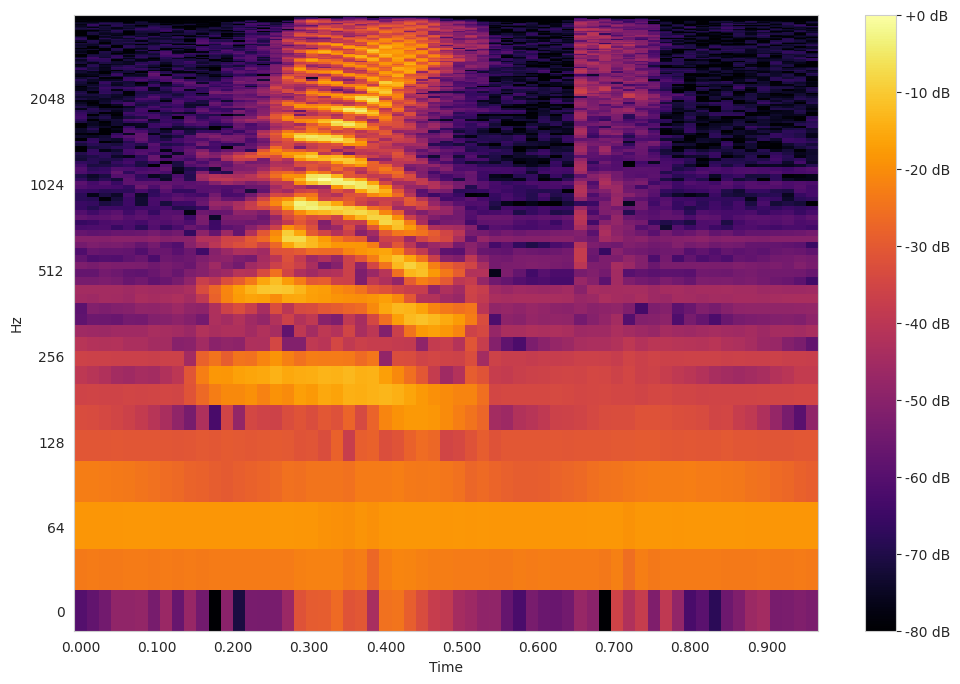

In [215]:
S_db = librosa.amplitude_to_db(np.abs(stft(data[514], fs=8e3, N=256, hop_size=128)[0]), ref=np.max)
# Plot the spectrogram
plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=8e3, cmap='inferno', hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

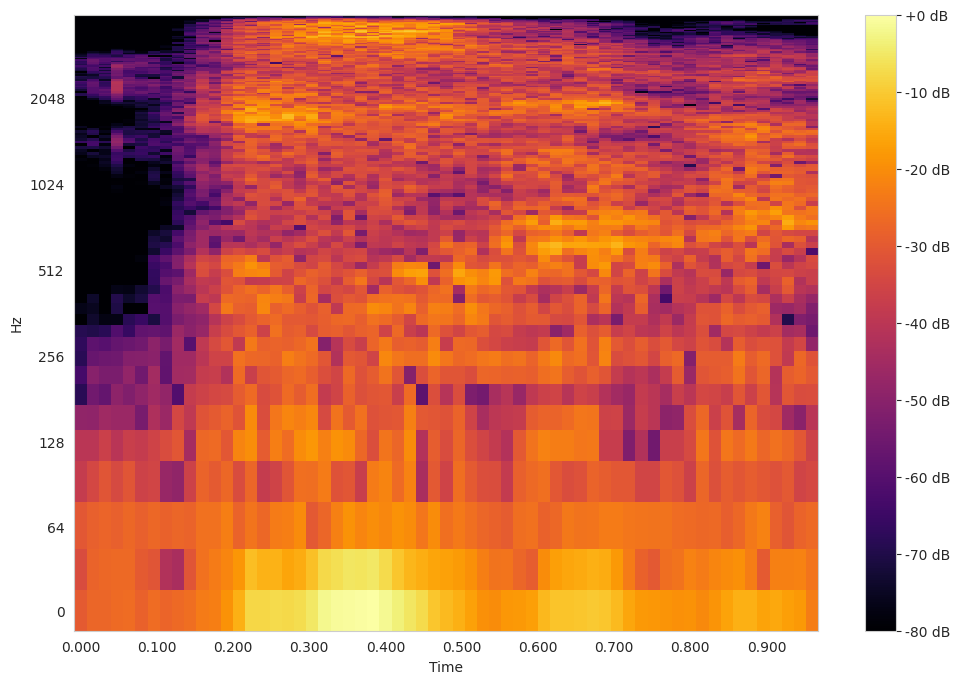

In [325]:
S_db = librosa.amplitude_to_db(np.abs(stft(samples[50], fs=8e3, N=256, hop_size=128)[0]), ref=np.max)
# Plot the spectrogram
plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=8e3, cmap='inferno', hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

# Fine tune the model

In [185]:
new_model = keras.models.clone_model(model)

for layer in new_model.layers:
    if isinstance(layer, keras.layers.Conv2D):
        layer.trainable = False
        
callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
]

new_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

EPOCHS = 100
history = new_model.fit(microphone_data_resized, labels,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=1000,
)

Epoch 1/100
2/2 [==============================] - 3s 408ms/step - loss: 2.6636 - accuracy: 0.1732 - val_loss: 1.8753 - val_accuracy: 0.1358
Epoch 2/100
2/2 [==============================] - 0s 47ms/step - loss: 2.6678 - accuracy: 0.1629 - val_loss: 1.8094 - val_accuracy: 0.1420
Epoch 3/100
2/2 [==============================] - 0s 52ms/step - loss: 2.2884 - accuracy: 0.1711 - val_loss: 1.7997 - val_accuracy: 0.1975
Epoch 4/100
2/2 [==============================] - 0s 46ms/step - loss: 2.3357 - accuracy: 0.1863 - val_loss: 1.8010 - val_accuracy: 0.1420
Epoch 5/100
2/2 [==============================] - 0s 47ms/step - loss: 2.1932 - accuracy: 0.1773 - val_loss: 1.8078 - val_accuracy: 0.1420
Epoch 6/100
2/2 [==============================] - 0s 51ms/step - loss: 2.2644 - accuracy: 0.1842 - val_loss: 1.8043 - val_accuracy: 0.1605
Epoch 7/100
2/2 [==============================] - 0s 48ms/step - loss: 2.1593 - accuracy: 0.1704 - val_loss: 1.7949 - val_accuracy: 0.1543
Epoch 8/100
2/2 [==

In [504]:
y_pred_model = model.predict(microphone_data_resized)

33/33 [==============================] - 0s 2ms/step


In [385]:
thresholds = {
    0: 0.5,  # go
    1: 0.5,  # left
    2: 0.5,  # right
    3: 0.5,  # stop
    4: 0.5   # unknown (require higher confidence for unknown)
}

adjusted_predictions = []
for probs in y_pred_model:
    max_prob = max(probs)
    predicted_class = np.argmax(probs)
    
    # Check if the max_prob exceeds the threshold for that class
    if max_prob >= thresholds[predicted_class]:
        adjusted_predictions.append(predicted_class)
    else:
        # Assign to a fallback class, e.g., "unknown" (class 5)
        adjusted_predictions.append(4)  # Fallback to 'unknown'


In [188]:
import seaborn as sns

In [505]:
model.evaluate(microphone_data_resized, tf.expand_dims(microphone_labels, 1))

33/33 [==============================] - 0s 2ms/step - loss: 0.8574 - accuracy: 0.6354


[0.8573797345161438, 0.6354166865348816]

In [506]:

confusion_mtx = tf.math.confusion_matrix(microphone_labels, adjusted_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} Shapes of all inputs must match: values[0].shape = [1056] != values[1].shape = [1309] [Op:Pack] name: stack

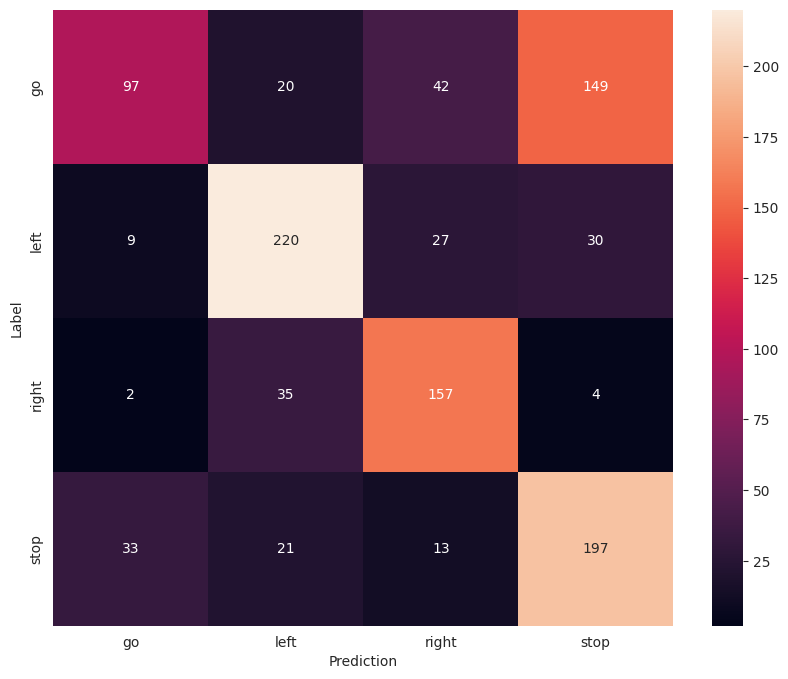

In [507]:

confusion_mtx = tf.math.confusion_matrix(microphone_labels, np.argmax(y_pred_model, axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [38]:
directory_path = "../Data_acquisition/data/audio/8kHz_sampling"
file_list = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

samples = []
labels = []

for file_name in file_list:
    with open(os.path.join(directory_path, file_name), 'r') as file:
        file_data = []
        reader = csv.DictReader(file)
        for row in reader:
            file_data.append(float(row['y']))  # Convert to int if y is numeric

        label_str = file_name.split("_")[0]
        if len(file_data) == 8e3:
            class_from_dict = prediction_dict_reversed.get(label_str)
            if class_from_dict is not None:
                labels.append(prediction_dict_reversed.get(label_str))
                samples.append(file_data)


microphone_data_dataset = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in samples]).astype(np.float32)
microphone_data_dataset = np.array([downsample_image_fixed(x.reshape(129*61), 129, 61, 32, 32) for x in microphone_data_dataset])
microphone_data_dataset_resized = microphone_data_dataset.reshape(len(microphone_data_dataset), microphone_data_dataset.shape[1], microphone_data_dataset.shape[2], 1)

# microphone_data = np.array([librosa.feature.mfcc(y=x, sr=8000, n_mfcc=16) for x in samples]).astype(np.float32)
# microphone_data_resized = microphone_data.reshape(len(microphone_data), microphone_data.shape[1], microphone_data.shape[2], 1)


microphone_labels_dataset = np.array(labels, dtype=np.int64)



def representative_dataset_gen():
    for input_value in microphone_data_dataset_resized[:2000]:
        yield [tf.expand_dims(input_value, 0)]


# Wrap the conversion in a custom_object_scope
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.float32  
converter.inference_output_type = tf.float32  
tflite_model = converter.convert()


with open('tra_qat_model.tflite', 'wb') as f:
    f.write(tflite_model)

model_Size = os.path.getsize("tra_qat_model.tflite")
print(f"Model ma {model_Size / 1e3} kB")

INFO:tensorflow:Assets written to: /tmp/tmpka97zgdi/assets


INFO:tensorflow:Assets written to: /tmp/tmpka97zgdi/assets
/home/vistek528/anaconda3/envs/DeepLearning/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1737248059.745792   11258 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1737248059.745803   11258 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-01-19 01:54:19.745939: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpka97zgdi
2025-01-19 01:54:19.747498: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-19 01:54:19.747510: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpka97zgdi
2025-01-19 01:54:19.757818: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-19 01:54:19.816983: I tensorflow/cc/saved_model/l

Model ma 150.888 kB


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


In [36]:
valid_data.shape

(1533, 32, 32, 1)

In [37]:
microphone_data_dataset_resized.shape

(51, 32, 32, 1)

In [62]:
selected_labels_str

['go', 'left', 'right', 'stop', 'silence', 'unknown']

In [39]:
interpreter = tf.lite.Interpreter(model_path="tra_qat_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Data Type:", input_details[0]['dtype'])

Input Shape: [ 1 32 32  1]
Input Data Type: <class 'numpy.float32'>


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [40]:
input_scale = 0.0078125
input_zero_point = -128
max_float_value = 32768.0

y_pred = []
y_pred_probabilities = []
correctly = 0

for sample, y_true in zip(microphone_data_dataset_resized, microphone_labels_dataset):
    # Przekształcenie danych wejściowych do INT8
    sample_int8 = np.clip((sample / max_float_value / input_scale) + input_zero_point, -128, 127).astype(np.int8)
    
    # Przekazanie danych do interpretera
    interpreter.set_tensor(input_details[0]['index'], tf.expand_dims(sample_int8, 0))
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])[0]
    
    # Odkwantyzacja wyjścia
    output_data_float = (output_data - input_zero_point) * input_scale
    
    # Klasyfikacja (argmax)
    predicted_class = np.argmax(output_data)
    y_pred_probabilities.append(output_data_float)  # Możesz zapisać odkwantyzowane wyjście dla analizy
    
    # Sprawdzenie poprawności klasyfikacji
    if predicted_class == y_true:
        correctly += 1
    y_pred.append(predicted_class)
    
    print(f"Y_pred={predicted_class} | Y_true={y_true}")
    print(output_data_float)


ValueError: Cannot set tensor: Got value of type INT8 but expected type FLOAT32 for input 0, name: serving_default_input_5:0 

In [337]:
thresholds = {
    0: 0.5,  # go
    1: 0.5,  # left
    2: 0.5,  # right
    3: 0.6,  # stop
    4: 0.1,  # silence
    5: 0.8   # unknown (require higher confidence for unknown)
}

adjusted_predictions = []
for probs in y_pred_probabilities:
    probs = probs[0]
    max_prob = max(probs)
    predicted_class = np.argmax(probs)
    
    # Check if the max_prob exceeds the threshold for that class
    if max_prob >= thresholds[predicted_class]:
        adjusted_predictions.append(predicted_class)
    else:
        # Assign to a fallback class, e.g., "unknown" (class 5)
        adjusted_predictions.append(5)  # Fallback to 'unknown'
correctly2 = 0
for y_pred_2, y_true in zip(adjusted_predictions, microphone_labels):
    if y_pred_2 == y_true:
        correctly2 += 1

In [287]:
len(labels)

23685

In [561]:
print(f"Accuracy: {(correctly/len(microphone_labels_dataset))*100:.2f}%")

Accuracy: 75.51%


In [338]:
print(f"Accuracy: {(correctly2/len(microphone_labels))*100:.2f}%")

Accuracy: 37.91%


In [154]:
labels

array([[4],
       [1],
       [1],
       ...,
       [0],
       [2],
       [3]])

In [123]:
import seaborn as sns

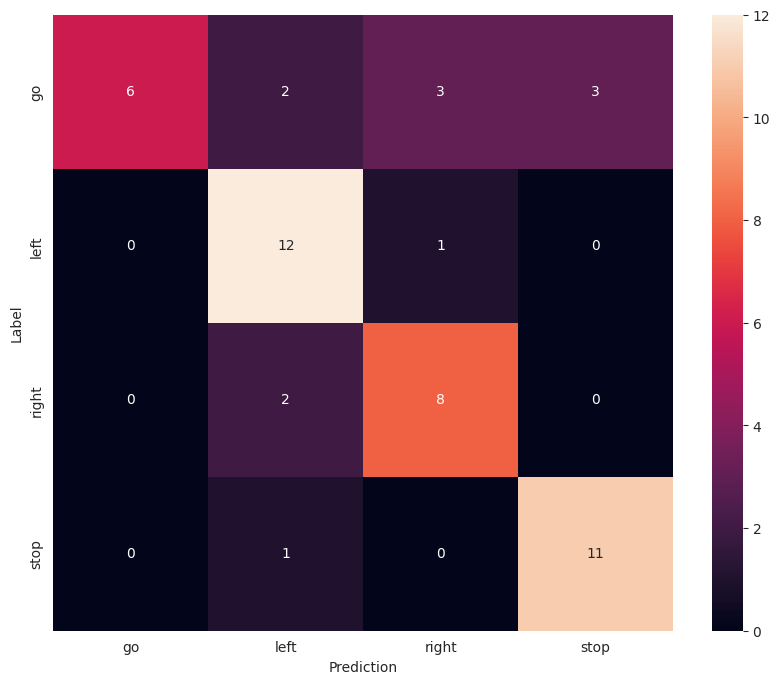

In [562]:

confusion_mtx = tf.math.confusion_matrix(microphone_labels_dataset, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [499]:
S, _, _ = stft(noise, fs=8000, N=256, hop_size=128)

In [502]:
np.abs(S)

array([[435.99113731, 482.37663555, 480.05789027, ..., 463.14276911,
        480.61503087, 432.05278079],
       [208.81383555, 238.35012289, 251.29561891, ..., 241.85701207,
        254.94971011, 204.59306768],
       [ 20.29911283,   1.89553186,  13.1480823 , ...,  17.72234188,
         37.32021157,  14.33772994],
       ...,
       [  5.03355162,  16.16285043,  28.68250135, ...,  10.21588269,
          6.78246755,   3.85476972],
       [ 11.76981259,  13.28726097,  25.80400156, ...,   7.47750887,
         22.67437402,  11.96070071],
       [  2.16472139,   1.06444376,  21.16600767, ...,   8.61588059,
         30.62261863,   3.08399227]])

In [590]:
audio_file = "../Data_acquisition/data/audio/8kHz_sampling/left_fs=8kHz_2.csv"
stft_file = "../Data_acquisition/data/stft/8kHz_sampling/stft_left_fs=8kHz_2.csv"

In [591]:
audio_data = []
with open(audio_file, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        audio_data.append(float(row['y']))  # Convert to int if y is numeric

audio_data = np.array(audio_data, dtype=np.float32)
print(f"Data length before resampling: {len(audio_data)}")
print(f"Data type before resampling: {type(audio_data[0])}")
display.Audio(audio_data, rate=8000)

Data length before resampling: 8000
Data type before resampling: <class 'numpy.float32'>


In [592]:
stft_data = []
with open(stft_file, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        stft_data.append(float(row['stft_value']))  # Convert to int if y is numeric

stft_data = np.array(stft_data, dtype=np.float32)
print(f"stft_data shape: {stft_data.shape}")

stft_data shape: (7869,)


In [593]:
stft_data = stft_data.reshape(129, 61, 1)
stft_data = tf.image.resize(stft_data, [32, 32])

In [594]:
stft_data.shape

TensorShape([32, 32, 1])

In [595]:
sample_int8 = np.clip((stft_data / max_float_value / input_scale) + input_zero_point, -128, 127).astype(np.int8)
    
# Przekazanie danych do interpretera
interpreter.set_tensor(input_details[0]['index'], tf.expand_dims(sample_int8, 0))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])[0]

# Odkwantyzacja wyjścia
output_data_float = (output_data - input_zero_point) * input_scale

# Klasyfikacja (argmax)
predicted_class = np.argmax(output_data)

In [596]:
prediction_dict.get(predicted_class)

'left'